In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.widgets as widgets

def display_images(images, titles, rows, cols, figsize=(15, 10)):
    """Helper function to display multiple images with titles"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, (image, title) in enumerate(zip(images, titles)):
        if len(image.shape) == 2 or image.shape[2] == 1:  # Grayscale
            axes[i].imshow(image, cmap='gray')
        else:  # Color
            axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def graphcut_segmentation(image):
    """
    Graph-cut segmentation using GrabCut algorithm
    """
    # Create mask and initialize with obvious background and foreground
    mask = np.zeros(image.shape[:2], np.uint8)

    # Set a rectangle for foreground (approximate)
    rect = (50, 50, image.shape[1]-100, image.shape[0]-100)

    # Create temporary arrays for GrabCut
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Apply GrabCut
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Modify mask: 0 and 2 to background (0), 1 and 3 to foreground (1)
    mask_output = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Multiply image with the mask to keep foreground
    result = image * mask_output[:, :, np.newaxis]

    return result

def meanshift_segmentation(image):
    """
    Mean Shift segmentation
    """
    # Convert image to feature space
    flat_image = image.reshape((-1, 3))
    flat_image = np.float32(flat_image)

    # Estimate bandwidth
    bandwidth = estimate_bandwidth(flat_image, quantile=0.1, n_samples=1000)

    # Apply mean shift
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(flat_image)

    # Get labels and centers
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    # Convert back to image
    segmented_image = cluster_centers[labels].reshape(image.shape).astype(np.uint8)

    return segmented_image



Performing Graph-cut segmentation...
Performing Mean Shift segmentation...


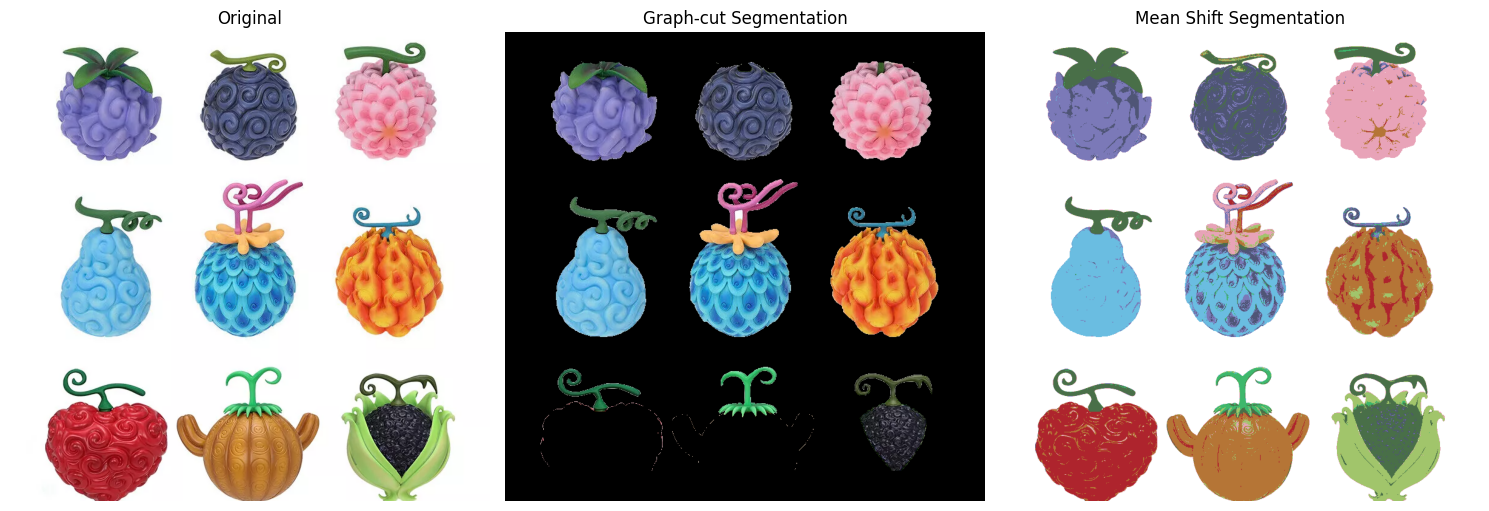

In [ ]:

def main():
    # Load image
    image_path = "devilfruits.png"
    image = cv2.imread(image_path)

    if image is None:
        print("Error: Could not load image. Please check the path.")
        return

    # Create a copy for display
    original = image.copy()

    # 1. Graph-cut segmentation
    print("Performing Graph-cut segmentation...")
    graphcut_result = graphcut_segmentation(image.copy())

    # 2. Mean Shift segmentation
    print("Performing Mean Shift segmentation...")
    meanshift_result = meanshift_segmentation(image.copy())

    # Display automatic segmentation results
    display_images(
        [original, graphcut_result, meanshift_result],
        ["Original", "Graph-cut Segmentation", "Mean Shift Segmentation"],
        1, 3
    )


if __name__ == "__main__":
    main()


Manual Thresholding
Using fixed threshold value of 127


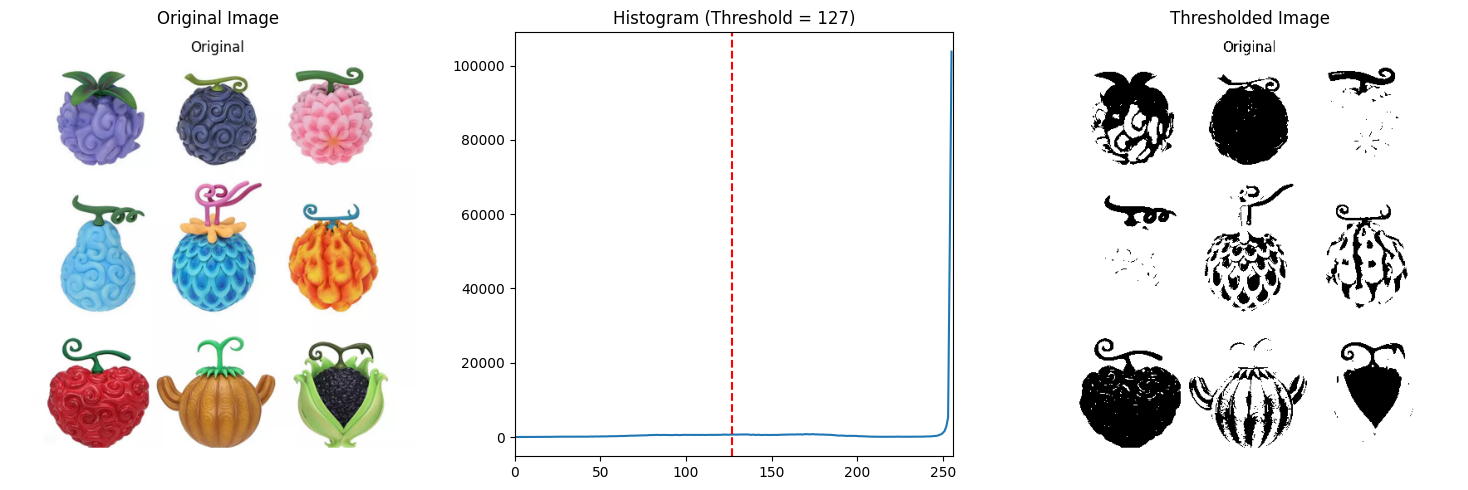


Manual K-means Clustering
Using fixed K value of 3


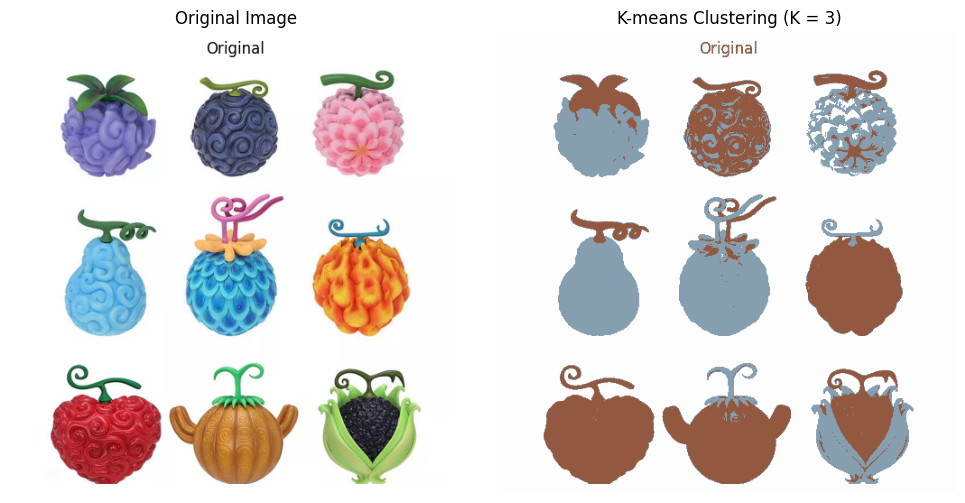

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def display_images(images, titles, rows, cols, figsize=(15, 10)):
    """Helper function to display multiple images with titles"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, (image, title) in enumerate(zip(images, titles)):
        if len(image.shape) == 2 or image.shape[2] == 1:  # Grayscale
            axes[i].imshow(image, cmap='gray')
        else:  # Color
            axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Manual Thresholding Tool - Without Slider
class ThresholdingTool:
    def __init__(self, image, threshold=127):
        self.image = image
        self.gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        self.threshold = threshold

        # Apply thresholding
        self.segmented_image = self.apply_threshold()

        # Display results
        self.display_results()

    def apply_threshold(self):
        _, binary = cv2.threshold(self.gray, self.threshold, 255, cv2.THRESH_BINARY)
        return binary

    def display_results(self):
        # Calculate histogram
        hist = cv2.calcHist([self.gray], [0], None, [256], [0, 256]).flatten()

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        axes[0].imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB) if len(self.image.shape) == 3 else self.gray, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Histogram with threshold line
        axes[1].plot(range(256), hist)
        axes[1].axvline(x=self.threshold, color='r', linestyle='--')
        axes[1].set_title(f'Histogram (Threshold = {self.threshold})')
        axes[1].set_xlim([0, 256])

        # Thresholded image
        axes[2].imshow(self.segmented_image, cmap='gray')
        axes[2].set_title('Thresholded Image')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

# Manual K-means Clustering Tool - Without Slider
class KMeansClusteringTool:
    def __init__(self, image, k=3):
        self.image = image
        self.k = k

        # Apply k-means clustering
        self.segmented_image = self.apply_kmeans()

        # Display results
        self.display_results()

    def apply_kmeans(self):
        # Reshape image for k-means
        data = self.image.reshape((-1, 3)).astype(np.float32)

        # Define criteria and apply k-means
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        _, labels, centers = cv2.kmeans(data, self.k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert back to 8-bit values
        centers = np.uint8(centers)

        # Map labels to colors
        segmented_image = centers[labels.flatten()].reshape(self.image.shape)
        return segmented_image

    def display_results(self):
        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Original image
        axes[0].imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Clustered image
        axes[1].imshow(cv2.cvtColor(self.segmented_image, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'K-means Clustering (K = {self.k})')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

def main():
    # Load image
    image_path = "df.png"
    image = cv2.imread(image_path)

    if image is None:
        print("Error: Could not load image")
        return

    # Create a copy for display
    original = image.copy()

    # Manual Thresholding with fixed value
    print("\nManual Thresholding")
    print("Using fixed threshold value of 127")
    thresholding_tool = ThresholdingTool(image.copy(), threshold=127)

    # Manual K-means Clustering with fixed value
    print("\nManual K-means Clustering")
    print("Using fixed K value of 3")
    kmeans_tool = KMeansClusteringTool(image.copy(), k=3)

if __name__ == "__main__":
    main()

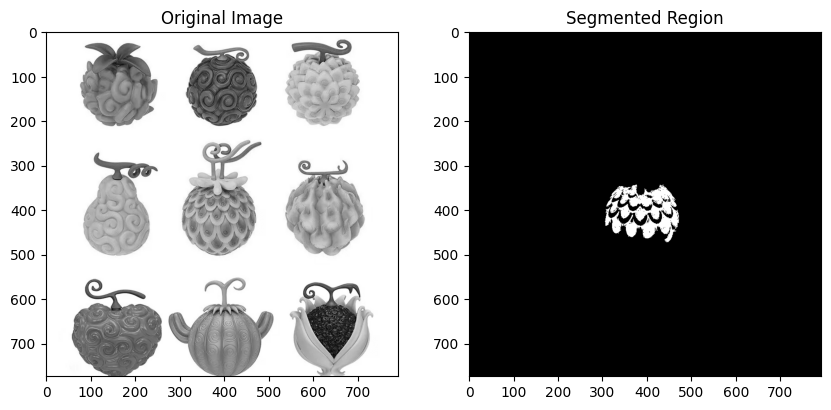

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return img

# Region growing function
def region_growing(img, threshold):
    height, width = img.shape
    segmented = np.zeros_like(img, dtype=np.uint8)
    visited = np.zeros_like(img, dtype=bool)

    # Automatic seed selection at center
    seed_x, seed_y = width // 2, height // 2
    seed_value = img[seed_y, seed_x]
    queue = [(seed_x, seed_y)]

    while queue:
        x, y = queue.pop(0)
        if visited[y, x]:
            continue
        visited[y, x] = True

        intensity_diff = abs(int(img[y, x]) - int(seed_value))

        # Check pixel intensity difference
        if intensity_diff <= threshold:
            segmented[y, x] = 255  # Mark as part of the region

            # Add neighboring pixels
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height and not visited[ny, nx]:
                    queue.append((nx, ny))

    return segmented

# Load image
image_path = "devilfruits.png"  # Change this
img = load_image(image_path)
threshold = 50
segmented_img = region_growing(img, threshold)

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(segmented_img, cmap='gray')
ax[1].set_title("Segmented Region")

plt.show()

print("Seed Point is:",queue)


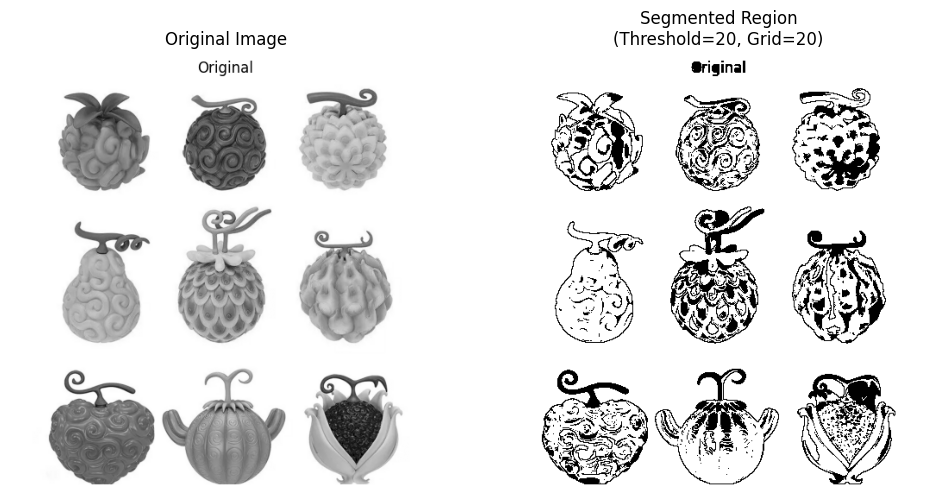

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return img

# Region growing function with multiple seeds
def region_growing_multi_seeds(img, threshold, grid_size=20):
    height, width = img.shape
    segmented = np.zeros_like(img, dtype=np.uint8)
    visited = np.zeros_like(img, dtype=bool)

    # Create grid of seed points
    seeds = []
    for y in range(0, height, grid_size):
        for x in range(0, width, grid_size):
            seeds.append((x, y))

    # Process each seed point
    for seed_x, seed_y in seeds:
        if visited[seed_y, seed_x]:
            continue

        seed_value = img[seed_y, seed_x]
        queue = [(seed_x, seed_y)]

        while queue:
            x, y = queue.pop(0)
            if visited[y, x]:
                continue
            visited[y, x] = True

            intensity_diff = abs(int(img[y, x]) - int(seed_value))

            # Check pixel intensity difference
            if intensity_diff <= threshold:
                segmented[y, x] = 255  # Mark as part of the region

                # Add neighboring pixels (8-connectivity)
                for dx, dy in [(-1, -1), (-1, 0), (-1, 1),
                             (0, -1),           (0, 1),
                             (1, -1),  (1, 0),  (1, 1)]:
                    nx, ny = x + dx, y + dy
                    if (0 <= nx < width and 0 <= ny < height and
                        not visited[ny, nx]):
                        queue.append((nx, ny))

    return segmented

# Load image
image_path = "df.png"  # Change this
img = load_image(image_path)

if img is None:
    print("Error: Could not load image")
    exit()

# Apply region growing with multiple seeds
threshold = 20
grid_size = 20  # Adjust this value to change seed point density (smaller = more seeds)
segmented_img = region_growing_multi_seeds(img, threshold, grid_size)

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(segmented_img, cmap='gray')
ax[1].set_title(f"Segmented Region\n(Threshold={threshold}, Grid={grid_size})")
ax[1].axis('off')

plt.tight_layout()
plt.show()

# Note: queue is not accessible here as it's local to the function
# If you want to see the final seed points used, you can modify the function to return them

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return img

# Region growing function for entire image
def region_growing_entire_image(img, grid_size=20, base_threshold=30):
    height, width = img.shape
    segmented = np.zeros_like(img, dtype=np.uint8)
    visited = np.zeros_like(img, dtype=bool)
    regions = []  # Store region information

    # Create grid of seed points
    seeds = []
    for y in range(0, height, grid_size):
        for x in range(0, width, grid_size):
            seeds.append((x, y))

    # Process each seed point
    for seed_x, seed_y in seeds:
        if visited[seed_y, seed_x]:
            continue

        seed_value = img[seed_y, seed_x]
        queue = [(seed_x, seed_y)]
        region_pixels = []

        while queue:
            x, y = queue.pop(0)
            if visited[y, x]:
                continue
            visited[y, x] = True

            # Calculate local threshold based on seed value
            intensity_diff = abs(int(img[y, x]) - int(seed_value))

            # Use adaptive threshold based on local intensity
            if intensity_diff <= base_threshold:
                region_pixels.append((x, y))
                # Instead of binary 255, use original intensity
                segmented[y, x] = img[y, x]

                # Check 8 neighbors
                for dx, dy in [(-1, -1), (-1, 0), (-1, 1),
                              (0, -1),          (0, 1),
                              (1, -1),  (1, 0),  (1, 1)]:
                    nx, ny = x + dx, y + dy
                    if (0 <= nx < width and 0 <= ny < height and
                        not visited[ny, nx]):
                        queue.append((nx, ny))

        if region_pixels:  # If region was found
            regions.append(region_pixels)

    # Fill any remaining unvisited pixels
    for y in range(height):
        for x in range(width):
            if not visited[y, x]:
                # Find nearest region and assign its average value
                min_dist = float('inf')
                assigned_value = 0
                for region in regions:
                    for rx, ry in region:
                        dist = np.sqrt((x - rx)**2 + (y - ry)**2)
                        if dist < min_dist:
                            min_dist = dist
                            assigned_value = img[ry, rx]
                segmented[y, x] = assigned_value

    return segmented

# Load image
image_path = "df.png"  # Change this
img = load_image(image_path)

if img is None:
    print("Error: Could not load image")
    exit()

# Apply region growing to entire image
grid_size = 20    # Distance between seed points
base_threshold = 30  # Base threshold value
segmented_img = region_growing_entire_image(img, grid_size, base_threshold)

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(segmented_img, cmap='gray')
ax[1].set_title(f"Segmented Entire Image\n(Grid={grid_size}, Threshold={base_threshold})")
ax[1].axis('off')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

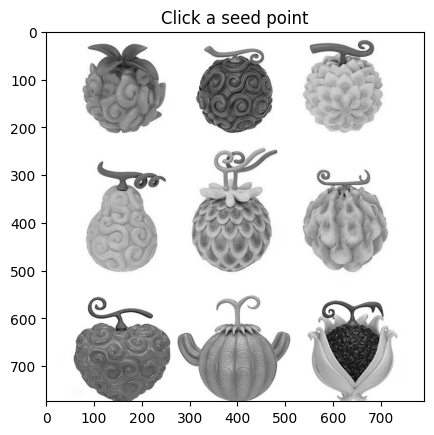

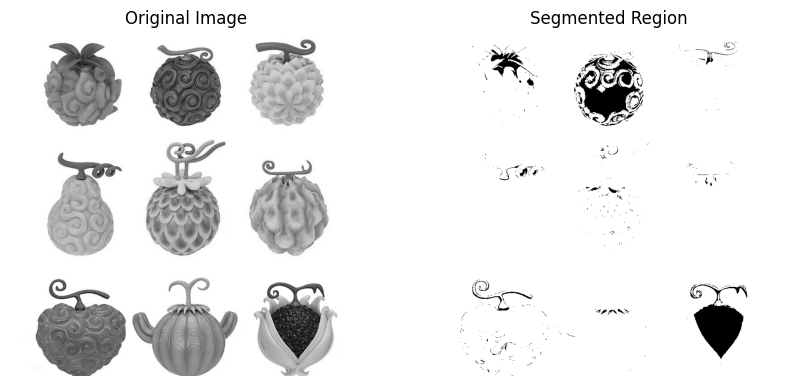

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Required for Colab

# Load grayscale image
image = cv2.imread("devilfruits.png", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found!")

# Parameters
threshold = 100
seed_point = (100,100)

# Region Growing Function (BFS)
def manual_region_grow(img, seed, threshold):
    h, w = img.shape
    segmented = np.zeros_like(img, dtype=np.uint8)
    visited = np.zeros_like(img, dtype=bool)

    seed_value = img[seed]
    queue = [seed]

    while queue:
        y, x = queue.pop(0)

        if visited[y, x]:
            continue

        visited[y, x] = True

        if abs(int(img[y, x]) - int(seed_value)) <= threshold:
            segmented[y, x] = 255

            # 4-neighbor check
            if x > 0: queue.append((y, x - 1))
            if x < w - 1: queue.append((y, x + 1))
            if y > 0: queue.append((y - 1, x))
            if y < h - 1: queue.append((y + 1, x))

    return segmented


# Perform segmentation
segmented_result = manual_region_grow(image, seed_point, threshold)

# Show results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(segmented_result, cmap='gray')
ax[1].set_title("Segmented Region")
ax[1].axis("off")

plt.show()


Performing Graph-cut segmentation...
Performing Mean Shift segmentation...

Manual Thresholding with fixed value of 127

Manual K-means Clustering with K=3

Performing Region Growing segmentation...


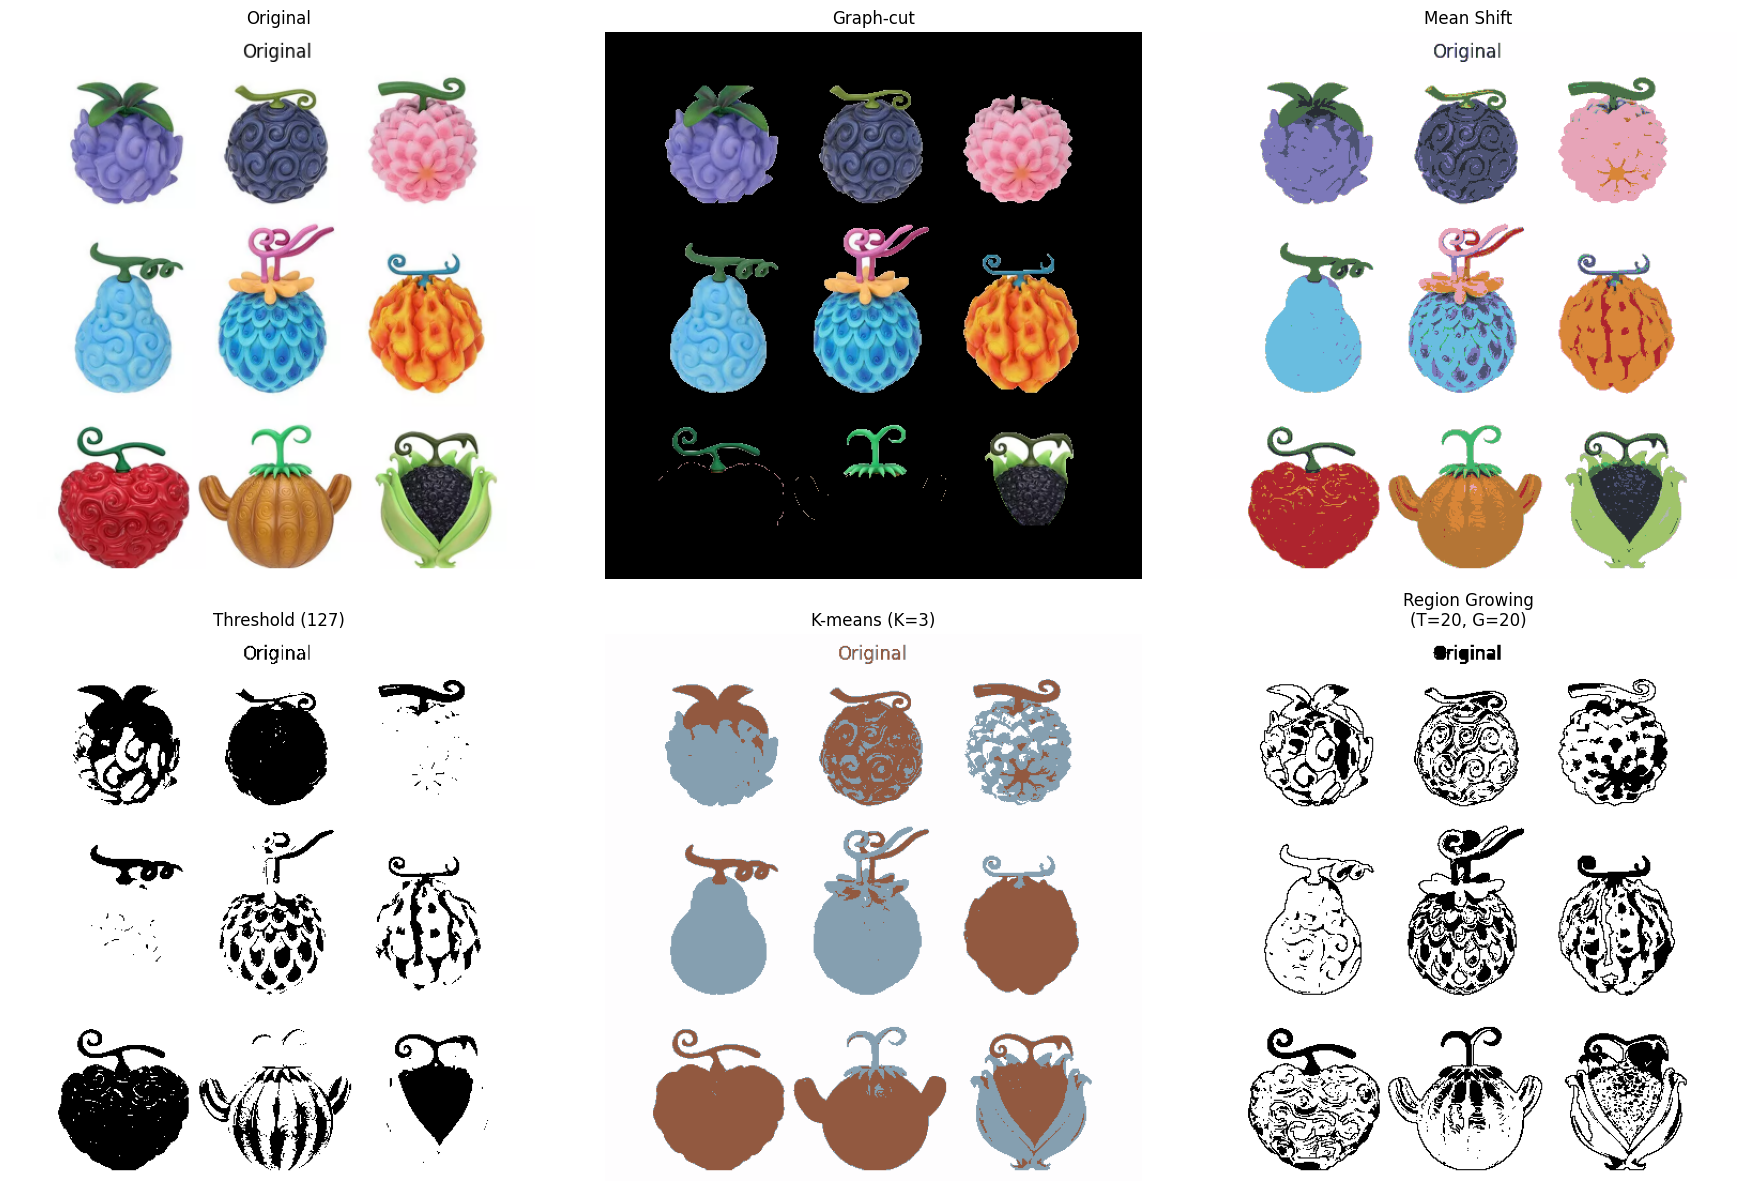

In [ ]:
#combined

import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

def display_images(images, titles, rows, cols, figsize=(15, 10)):
    """Helper function to display multiple images with titles"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, (image, title) in enumerate(zip(images, titles)):
        if len(image.shape) == 2 or image.shape[2] == 1:  # Grayscale
            axes[i].imshow(image, cmap='gray')
        else:  # Color
            axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Graph-cut Segmentation
def graphcut_segmentation(image):
    mask = np.zeros(image.shape[:2], np.uint8)
    rect = (50, 50, image.shape[1]-100, image.shape[0]-100)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    mask_output = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    result = image * mask_output[:, :, np.newaxis]
    return result

# Mean Shift Segmentation
def meanshift_segmentation(image):
    flat_image = image.reshape((-1, 3)).astype(np.float32)
    bandwidth = estimate_bandwidth(flat_image, quantile=0.1, n_samples=1000)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(flat_image)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    segmented_image = cluster_centers[labels].reshape(image.shape).astype(np.uint8)
    return segmented_image

# Thresholding Tool
class ThresholdingTool:
    def __init__(self, image, threshold=127):
        self.image = image
        self.gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        self.threshold = threshold
        self.segmented_image = self.apply_threshold()

    def apply_threshold(self):
        _, binary = cv2.threshold(self.gray, self.threshold, 255, cv2.THRESH_BINARY)
        return binary

# K-means Clustering Tool
class KMeansClusteringTool:
    def __init__(self, image, k=3):
        self.image = image
        self.k = k
        self.segmented_image = self.apply_kmeans()

    def apply_kmeans(self):
        data = self.image.reshape((-1, 3)).astype(np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        _, labels, centers = cv2.kmeans(data, self.k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        centers = np.uint8(centers)
        segmented_image = centers[labels.flatten()].reshape(self.image.shape)
        return segmented_image

# Region Growing with Multiple Seeds
def region_growing_multi_seeds(img, threshold, grid_size=20):
    height, width = img.shape
    segmented = np.zeros_like(img, dtype=np.uint8)
    visited = np.zeros_like(img, dtype=bool)

    seeds = []
    for y in range(0, height, grid_size):
        for x in range(0, width, grid_size):
            seeds.append((x, y))

    for seed_x, seed_y in seeds:
        if visited[seed_y, seed_x]:
            continue
        seed_value = img[seed_y, seed_x]
        queue = [(seed_x, seed_y)]

        while queue:
            x, y = queue.pop(0)
            if visited[y, x]:
                continue
            visited[y, x] = True
            intensity_diff = abs(int(img[y, x]) - int(seed_value))

            if intensity_diff <= threshold:
                segmented[y, x] = 255
                for dx, dy in [(-1, -1), (-1, 0), (-1, 1),
                              (0, -1),          (0, 1),
                              (1, -1),  (1, 0),  (1, 1)]:
                    nx, ny = x + dx, y + dy
                    if (0 <= nx < width and 0 <= ny < height and
                        not visited[ny, nx]):
                        queue.append((nx, ny))
    return segmented

def main():
    # Load image
    image_path = "df.png"  # Adjust path as needed
    image = cv2.imread(image_path)
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None or gray_image is None:
        print("Error: Could not load image. Please check the path.")
        return

    # Create a copy for display
    original = image.copy()

    # 1. Graph-cut segmentation
    print("Performing Graph-cut segmentation...")
    graphcut_result = graphcut_segmentation(image.copy())

    # 2. Mean Shift segmentation
    print("Performing Mean Shift segmentation...")
    meanshift_result = meanshift_segmentation(image.copy())

    # 3. Thresholding
    print("\nManual Thresholding with fixed value of 127")
    thresh_tool = ThresholdingTool(image.copy(), threshold=127)
    thresh_result = thresh_tool.segmented_image

    # 4. K-means Clustering
    print("\nManual K-means Clustering with K=3")
    kmeans_tool = KMeansClusteringTool(image.copy(), k=3)
    kmeans_result = kmeans_tool.segmented_image

    # 5. Region Growing
    print("\nPerforming Region Growing segmentation...")
    region_threshold = 20
    region_grid_size = 20
    region_result = region_growing_multi_seeds(gray_image.copy(), region_threshold, region_grid_size)

    # Display all results
    display_images(
        [original, graphcut_result, meanshift_result, thresh_result, kmeans_result, region_result],
        ["Original",
         "Graph-cut",
         "Mean Shift",
         "Threshold (127)",
         "K-means (K=3)",
         f"Region Growing\n(T={region_threshold}, G={region_grid_size})"],
        2, 3, figsize=(18, 12)
    )

if __name__ == "__main__":
    main()

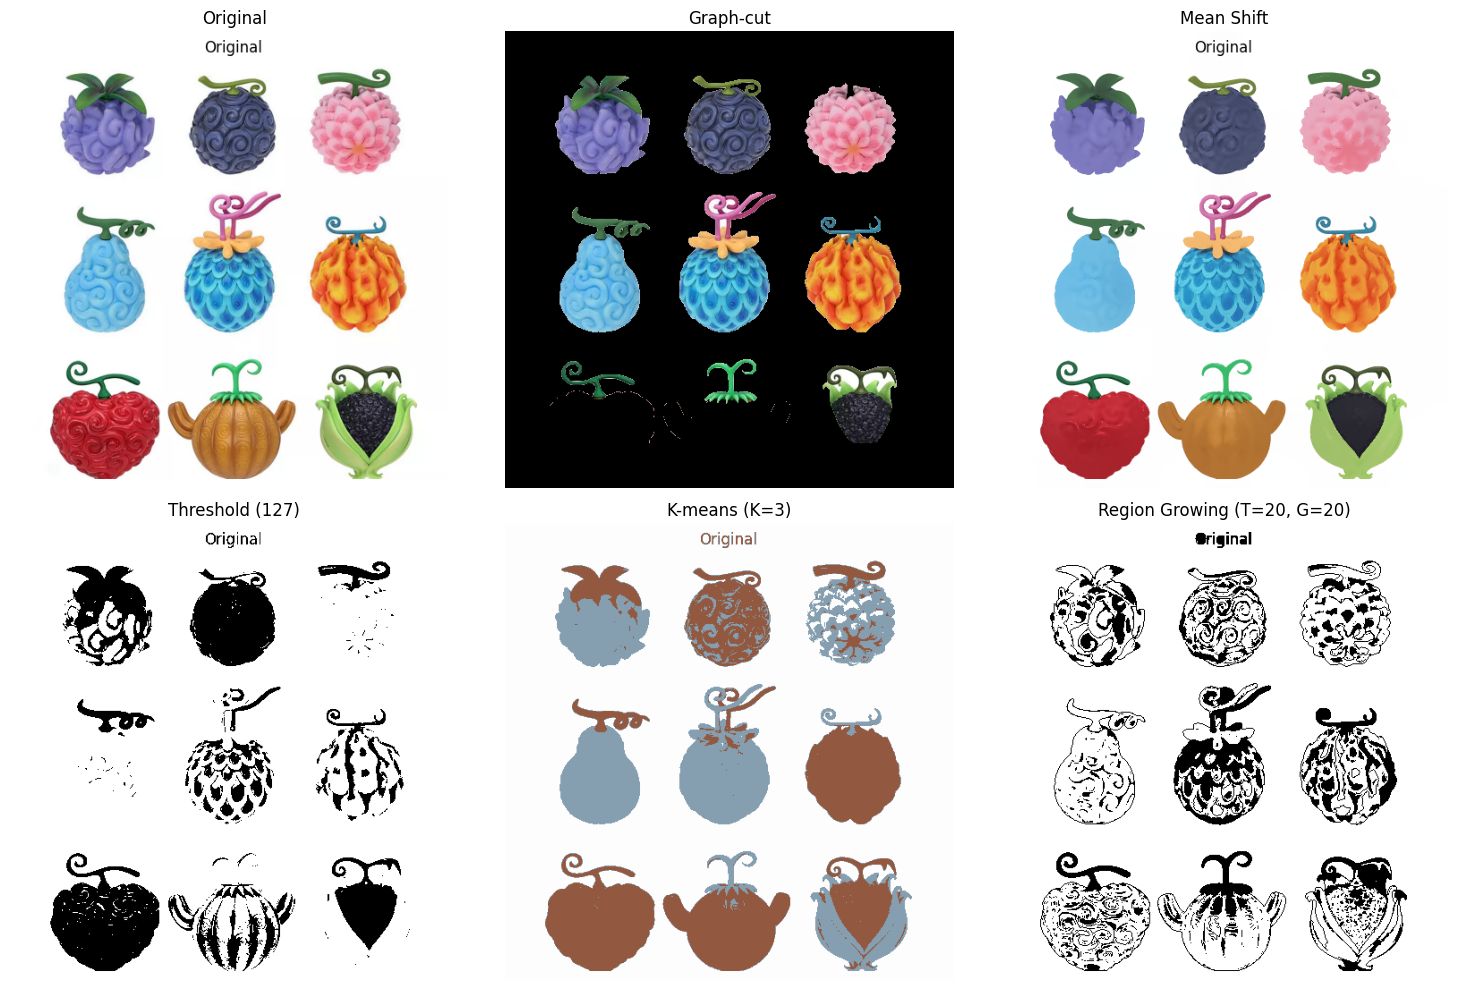

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def display_images(images, titles ,figsize=(15, 10)):
    """Helper function to display multiple images with titles"""
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    for i, (image, title) in enumerate(zip(images, titles)):
        if len(image.shape) == 2 or image.shape[2] == 1:  # Grayscale
            axes[i].imshow(image, cmap='gray')
        elif  len(image.shape) == 3 :  # Color
            axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else :
          None
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def graphcut_segmentation(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.grabCut(img, mask, (50, 50, img.shape[1]-100, img.shape[0]-100), None, None, 5, cv2.GC_INIT_WITH_RECT)
    return img * (np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')[:, :, np.newaxis])

def meanshift_segmentation(img):
    return cv2.pyrMeanShiftFiltering(img, sp=20, sr=30, maxLevel=1)

def threshold_segmentation(img, thresh=127):
    return cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), thresh, 255, cv2.THRESH_BINARY)[1]

def kmeans_segmentation(img, k=3):
    data = img.reshape((-1, 3)).astype(np.float32)
    _, labels, centers = cv2.kmeans(data, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2), 10, cv2.KMEANS_RANDOM_CENTERS)
    return centers[labels.flatten()].reshape(img.shape).astype(np.uint8)



def region_growing(img, thresh=20, grid=20):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    seg = np.zeros_like(gray)
    visited = np.zeros_like(gray, dtype=bool)
    seeds = [(x, y) for y in range(0, h, grid) for x in range(0, w, grid)]

    for sx, sy in seeds:
        if visited[sy, sx]: continue
        sv = gray[sy, sx]
        queue = [(sx, sy)]
        while queue:
            x, y = queue.pop(0)
            if visited[y, x]: continue
            visited[y, x] = True
            if abs(int(gray[y, x]) - int(sv)) <= thresh:
                seg[y, x] = 255
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 4-connectivity for speed
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < w and 0 <= ny < h and not visited[ny, nx]:
                        queue.append((nx, ny))
    return seg
def main():
    img = cv2.imread("df.png")
    if img is None:
        print("Error: Image not loaded")
        return

    results = [
        img,
        graphcut_segmentation(img.copy()),
        meanshift_segmentation(img.copy()),
        threshold_segmentation(img.copy()),
        kmeans_segmentation(img.copy()),
        region_growing(img.copy())
    ]
    titles = ["Original", "Graph-cut", "Mean Shift", "Threshold (127)", "K-means (K=3)", "Region Growing (T=20, G=20)"]

    display_images(results, titles)

if __name__ == "__main__":
    main()